## Imports

In [1]:
import pandas               as pd
import plotly.graph_objects as go
import matplotlib.pyplot    as plt
import numpy                as np
import seaborn              as sns

In [2]:
df = pd.read_csv("./Data/cleaned_govtrades.csv")
df_lawsuits = pd.read_csv("./Data/cleaned_stanford.csv")
df["Estimated Holdings"] = df["Estimated Holdings"].str[1:].str.replace(",", "")
df["Estimated Holdings"] = df["Estimated Holdings"].astype(int)
df["Party"] = df["Senator"].str[-5]
df["State"] = df["Senator"].str[-3:-1]
df

,Senator,Estimated Holdings,Symbol,Company,Sector,Industry,Party,State
0,Susan Collins (R-ME),42333400,MMM,3M Company,Health Care,Medical/Dental Instruments,R,ME
1,Mark Warner (D-VA),23574100,BDJ,Blackrock Enhanced Equity Divid Trust,Finance,Investment Managers,D,VA
2,Mitch McConnell (R-KY),12320800,VFIAX,Vanguard 500 Index Admiral Fund,Finance,Investment Managers,R,KY
3,Dianne Feinstein (D-CA),9205300,CBRE,CBRE Group,Finance,Investment Managers,D,CA
4,Elizabeth Warren (D-MA),8439900,TRGIX,TIAA-CREF Growth & Income Retirement Fund,Finance,Investment Managers,D,MA
...,...,...,...,...,...,...,...,...
2491,Jerry Moran (R-KS),0,RIG,Transocean Ltd,Energy,Oil & Gas Drilling,R,KS
2492,John Boozman (R-AR),0,VCSH,Vanguard Short-term Corporate Bond,Finance,ETFs,R,AR
2493,Gary Peters (D-MI),0,MCC,Medley Capital Corp,Finance,Closed-End Funds,D,MI
2494,Patty Murray (D-WA),0,MET,MetLife Inc,Financial Services,Insurance - Life,D,WA


## GovTrades Analysis

### Which Sectors have Senators invested in?

In [3]:
def getSumCount(df, group_col, agg_col):
    grouped_holdings = df.groupby(group_col).agg({agg_col: ["sum", "count"]}).reset_index()
    grouped_holdings.columns = [' '.join(col).strip() for col in grouped_holdings.columns.values]
    return grouped_holdings

In [4]:
sector_holdings = getSumCount(df, "Sector", "Estimated Holdings")
sector_holdings

,Sector,Estimated Holdings sum,Estimated Holdings count
0,Basic Industries,1635600,89
1,Basic Materials,700,1
2,Capital Goods,77321000,54
3,Consumer Cyclical,1800,6
4,Consumer Defensive,900,2
5,Consumer Discretionary,600,2
6,Consumer Durables,456600,10
7,Consumer Non-Durables,5879700,166
8,Consumer Services,45995000,439
9,Consumer Staples,100,1


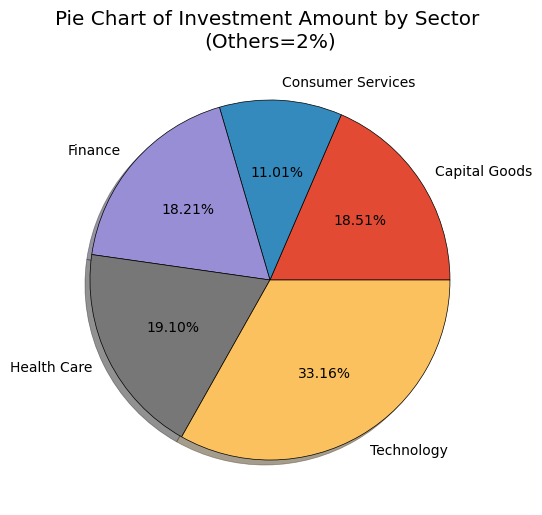

In [5]:
scale = 1e5
pie_sector_data = sector_holdings["Estimated Holdings sum"]/scale
pie_sector_data /= pie_sector_data.sum()
pie_sector_data *= 100
indices = pie_sector_data>2

with plt.style.context('ggplot'):
    _ = plt.pie(pie_sector_data[indices], labels = sector_holdings["Sector"][indices]
                , wedgeprops={"edgecolor": "black"}, autopct="%1.2f%%"
                , shadow=True)
    plt.tight_layout()
    plt.title("Pie Chart of Investment Amount by Sector \n(Others=2%)")
    plt.show()
plt.close()
# https://scc.ms.unimelb.edu.au/resources/data-visualisation-and-exploration/no_pie-charts

### How does Estimated Investment depend on the State the Senator is from?

In [6]:
state_holdings = df.groupby('State')['Estimated Holdings'].sum().reset_index()

In [7]:
scale = 1e5
fig = go.Figure(data=[
    go.Scattergeo(
    locationmode='USA-states',
    locations=state_holdings['State'],    
    text=(state_holdings['Estimated Holdings']/scale).round(2),
    showlegend=False,
    marker=dict(
        size=state_holdings['Estimated Holdings'] / scale, 
        color='skyblue',
        line=dict(width=1, color='DarkSlateGray'),
        sizemode='area',
        )

    ),
    go.Scattergeo(
        locationmode='USA-states',
        locations=state_holdings['State'],
        text=state_holdings['State'],  # State names near states
        mode='text',
        textposition='top left',  # State names above bubbles
        showlegend=False, #prevent legend from showing up.
    )
    ]
)

fig.update_layout(
    title_text='Estimated Holdings by State',
    geo=dict(
        scope='usa',
        # projection_type='albers usa',
        # showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    )
)
fig.show()

### How  diversified are Senators' investements by Party?

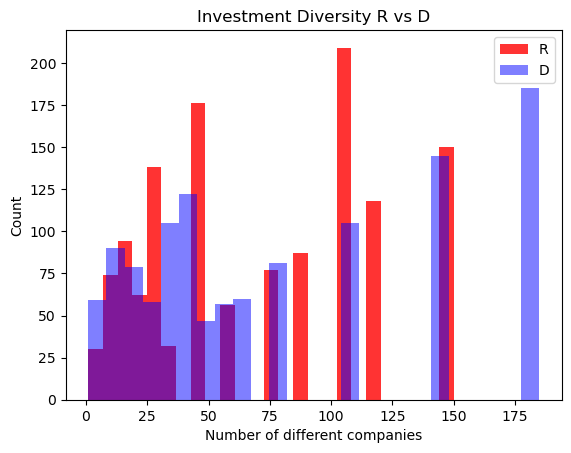

In [8]:
df_senator_party = df[["Senator", "Party"]]
df_senator_count_total = df.groupby("Senator").agg({"Party": "count"}).reset_index()
df_senator_count_total.columns = ["Senator", "Count"]
df_senator_count_total = pd.merge(df_senator_count_total, df_senator_party, on="Senator", how="left")

ra= plt.hist(df_senator_count_total[df_senator_count_total["Party"]=="R"]["Count"], histtype="bar", alpha=0.8, color="red", label="R", bins=25)
da= plt.hist(df_senator_count_total[df_senator_count_total["Party"]=="D"]["Count"], histtype="bar", alpha=0.5, color="blue", label="D", bins=25)
plt.legend()

plt.title("Investment Diversity R vs D")
plt.xlabel("Number of different companies")
plt.ylabel('Count')
plt.show()
plt.close()

In [9]:
df_senator_count_r = df_senator_count_total[df_senator_count_total["Party"]=="R"]["Count"].reset_index()
df_senator_count_d = df_senator_count_total[df_senator_count_total["Party"]=="D"]["Count"].reset_index()

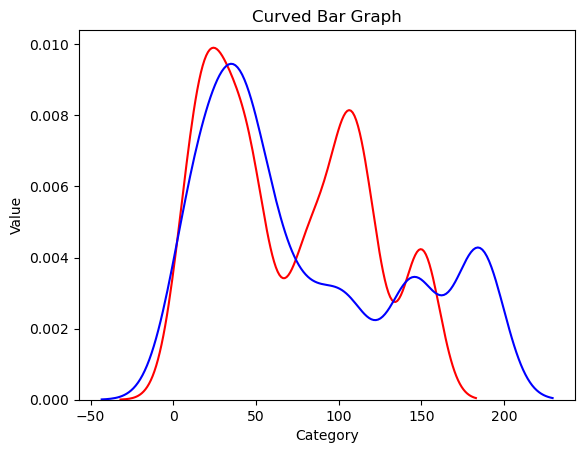

In [10]:
# fig, ax = plt.subplots()
sns.kdeplot(data=df_senator_count_r, x="Count", color="red")#, kind="kde"
sns.kdeplot(data=df_senator_count_d, x="Count", color="blue")#, kind="kde"
# sns.lineplot(x=ra[1][:-1], y=ra[0])

plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Curved Bar Graph')
plt.show()

## Stanford CA Analysis

View categories of companies with class action lawsuits.

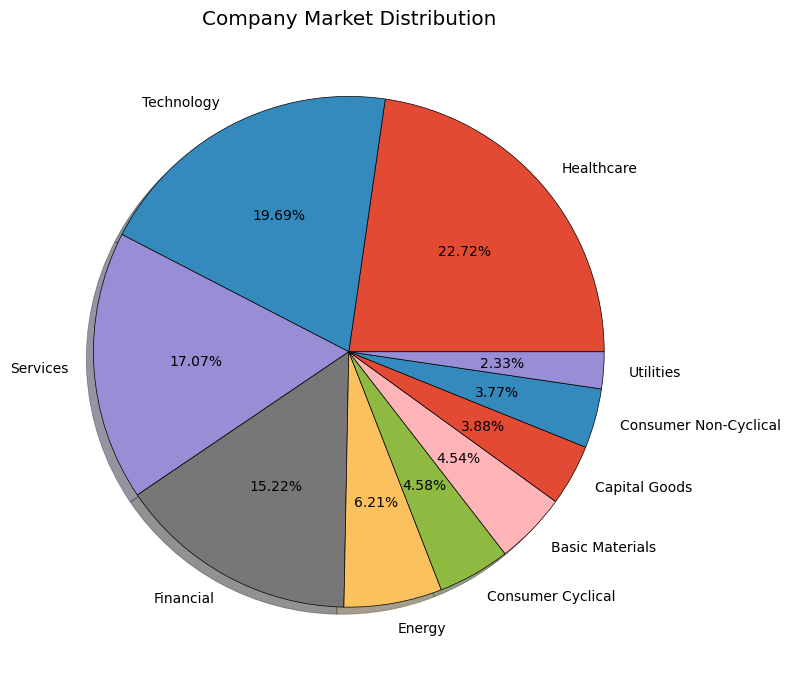

In [11]:
market_counts = df_lawsuits["comp_classification_sector_luv"].value_counts(normalize=True) * 100

# Filter for significant categories (optional)
filtered_data = market_counts[market_counts > 2]
filtered_labels = filtered_data.index

# Plot the pie chart
with plt.style.context("ggplot"):
    plt.figure(figsize=(8, 8))
    plt.pie(
        filtered_data,
        labels=filtered_labels,
        wedgeprops={"edgecolor": "black"},
        autopct="%1.2f%%",
        shadow=True
    )
    plt.title("Company Market Distribution")
    plt.tight_layout()
    plt.show()
plt.close()

What are the companies with the most class action lawsuits?

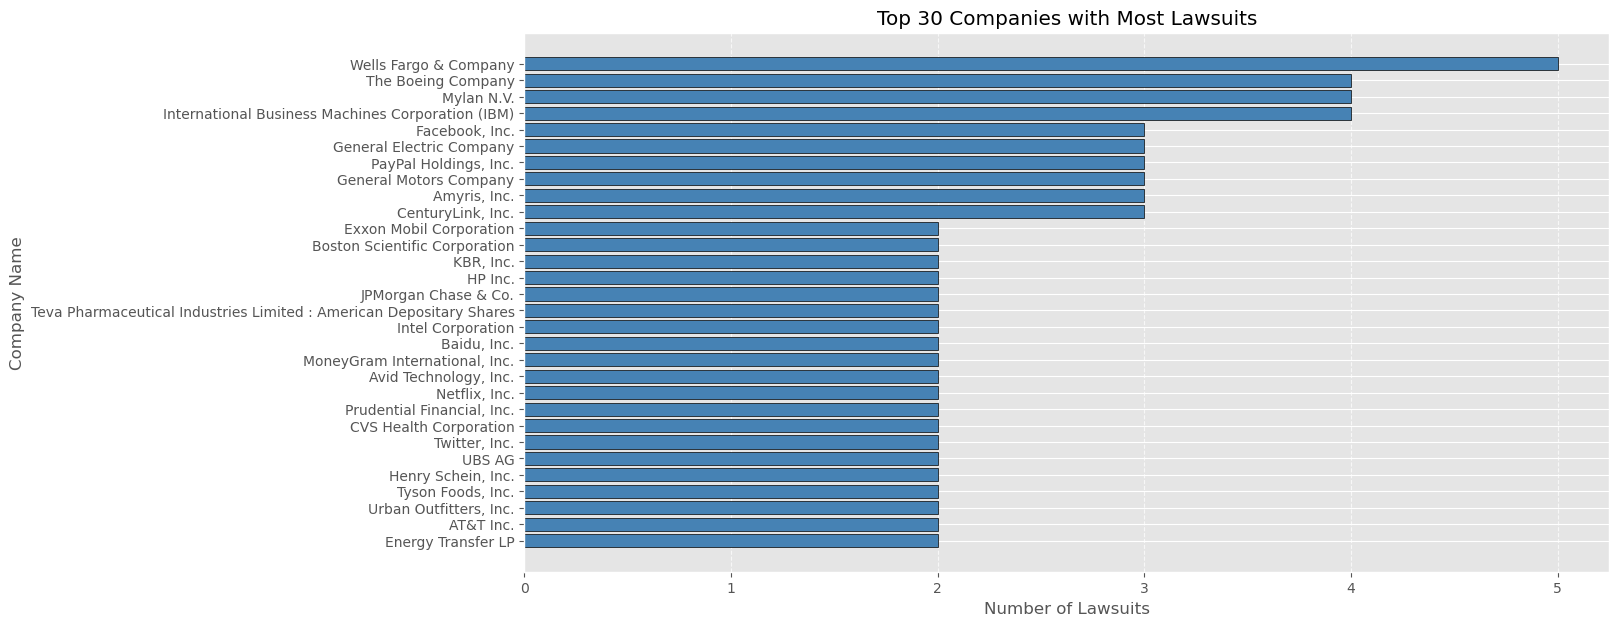

In [12]:
company_list = set(df["Symbol"])
filtered_lawsuits = df_lawsuits[df_lawsuits["company_ticker_symbol"].isin(company_list)]
lawsuit_counts = filtered_lawsuits["composite_litigation_name"].value_counts()

top_n = 30  # Adjust as needed
lawsuit_counts = lawsuit_counts.head(top_n)

# Plot the bar chart
with plt.style.context("ggplot"):
    plt.figure(figsize=(14, 7))
    plt.barh(lawsuit_counts.index[::-1], lawsuit_counts.values[::-1], 
             color="steelblue", edgecolor="black")
    plt.xlabel("Number of Lawsuits")
    plt.ylabel("Company Name")
    plt.title(f"Top {top_n} Companies with Most Lawsuits")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()
plt.close()

Are settlements/dismissals more or less likely when senators have holdings?

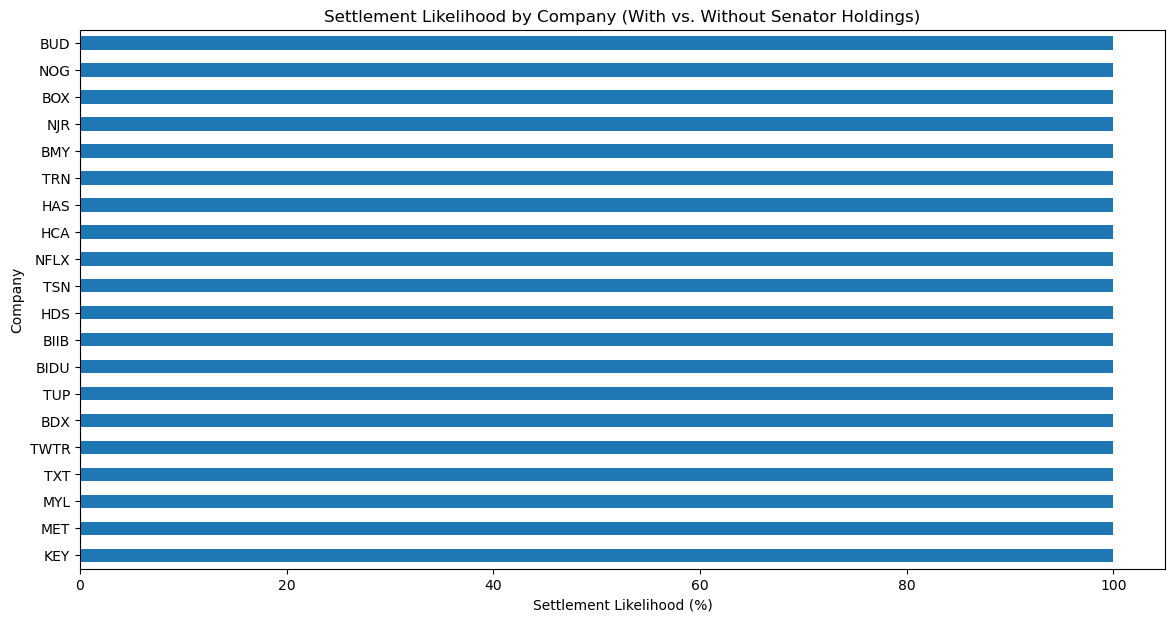

In [13]:
df['has_senator_holdings'] = df['Estimated Holdings'] > 0
settlement_dismissal_df = df_lawsuits[df_lawsuits['cld_case_status_gen_luv'].isin(['CASE SETTLED', 'CASE DISMISSED'])].copy()
companies_with_holdings = set(df[df['has_senator_holdings']]['Symbol'])
settlement_dismissal_df.loc[:, 'has_senator_holdings'] = settlement_dismissal_df['company_ticker_symbol'].isin(companies_with_holdings)

# Group by ticker symbol, count cases
company_lawsuit_counts = settlement_dismissal_df.groupby(['company_ticker_symbol', 'has_senator_holdings'])['composite_litigation_name'].count().unstack().fillna(0)

# Calculate the likelihood of settlement or dismissal
company_lawsuit_counts['settlement_likelihood'] = (company_lawsuit_counts[True] / (company_lawsuit_counts[True] + company_lawsuit_counts[False])) * 100

top_companies = company_lawsuit_counts.sort_values(by='settlement_likelihood', ascending=False).head(20)

# Plot the settlement likelihood for the top 20 companies
top_companies['settlement_likelihood'].plot(kind='barh', figsize=(14, 7))
plt.title('Settlement Likelihood by Company (With vs. Without Senator Holdings)')
plt.xlabel('Settlement Likelihood (%)')
plt.ylabel('Company')
plt.show()

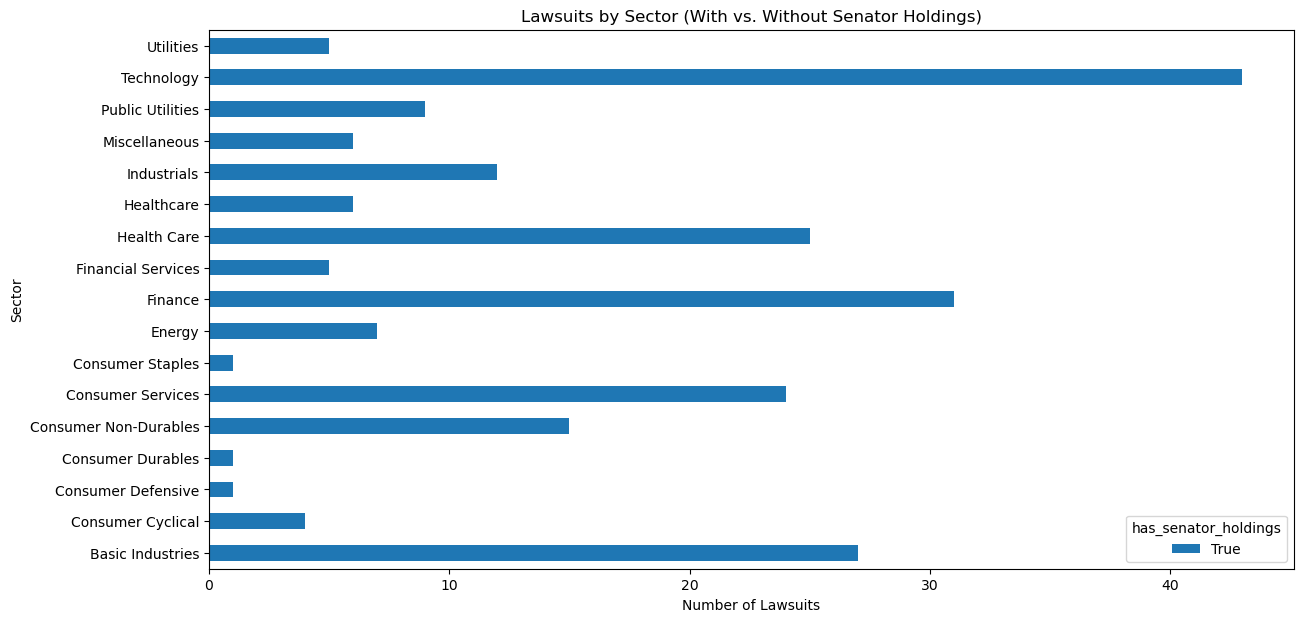

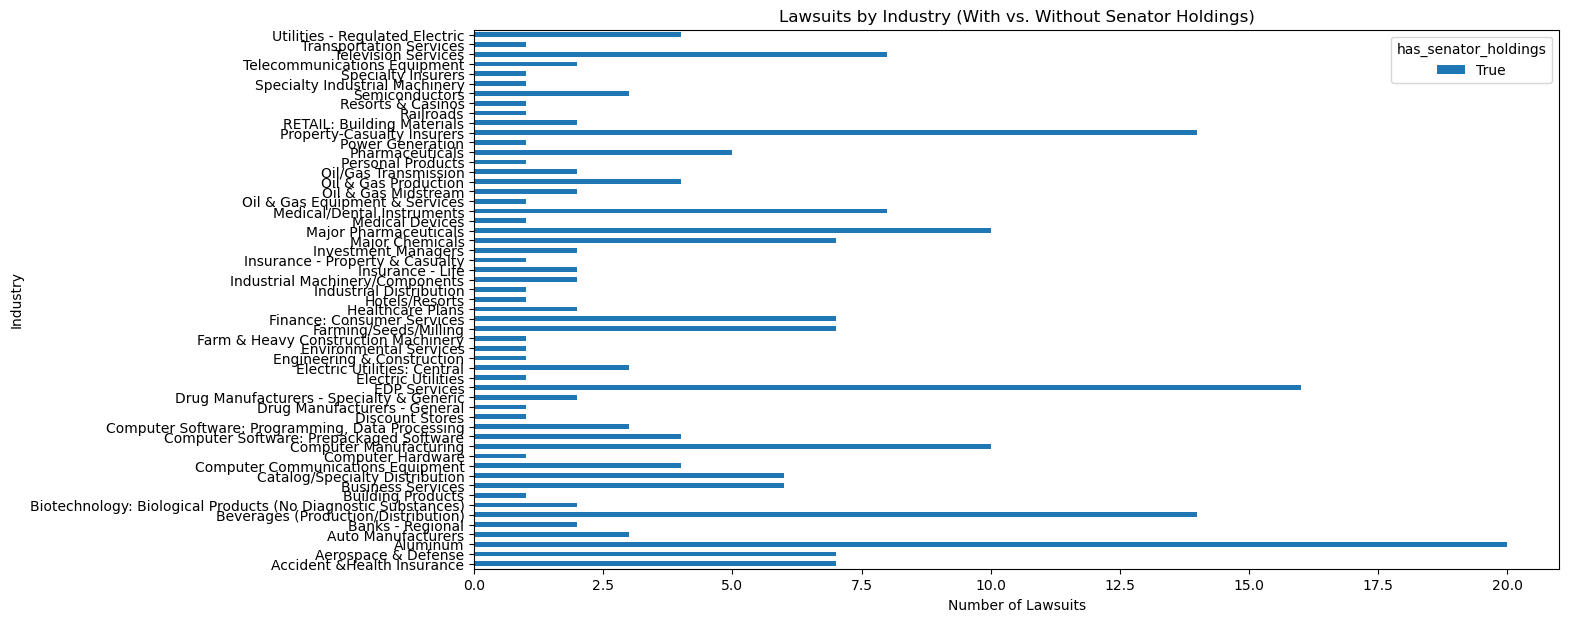

In [14]:
settlement_dismissal_df.loc[:, 'has_senator_holdings'] = settlement_dismissal_df['company_ticker_symbol'].isin(companies_with_holdings)

sector_mapping = df.set_index('Symbol')['Sector'].to_dict()
industry_mapping = df.set_index('Symbol')['Industry'].to_dict()

settlement_dismissal_df['Sector']   = settlement_dismissal_df['company_ticker_symbol'].map(sector_mapping)
settlement_dismissal_df['Industry'] = settlement_dismissal_df['company_ticker_symbol'].map(industry_mapping)

# Group by sector
sector_lawsuit_counts = settlement_dismissal_df.groupby(['Sector', 'has_senator_holdings'])['composite_litigation_name'].count().unstack(fill_value=0)

# Group by industry
industry_lawsuit_counts = settlement_dismissal_df.groupby(['Industry', 'has_senator_holdings'])['composite_litigation_name'].count().unstack(fill_value=0)

# Number of lawsuits by sector
sector_lawsuit_counts.plot(kind='barh', stacked=True, figsize=(14, 7))
plt.title('Lawsuits by Sector (With vs. Without Senator Holdings)')
plt.xlabel('Number of Lawsuits')
plt.ylabel('Sector')
plt.show()

# Number of lawsuits by industry
industry_lawsuit_counts.plot(kind='barh', stacked=True, figsize=(14, 7))
plt.title('Lawsuits by Industry (With vs. Without Senator Holdings)')
plt.xlabel('Number of Lawsuits')
plt.ylabel('Industry')
plt.show()

Trend over time

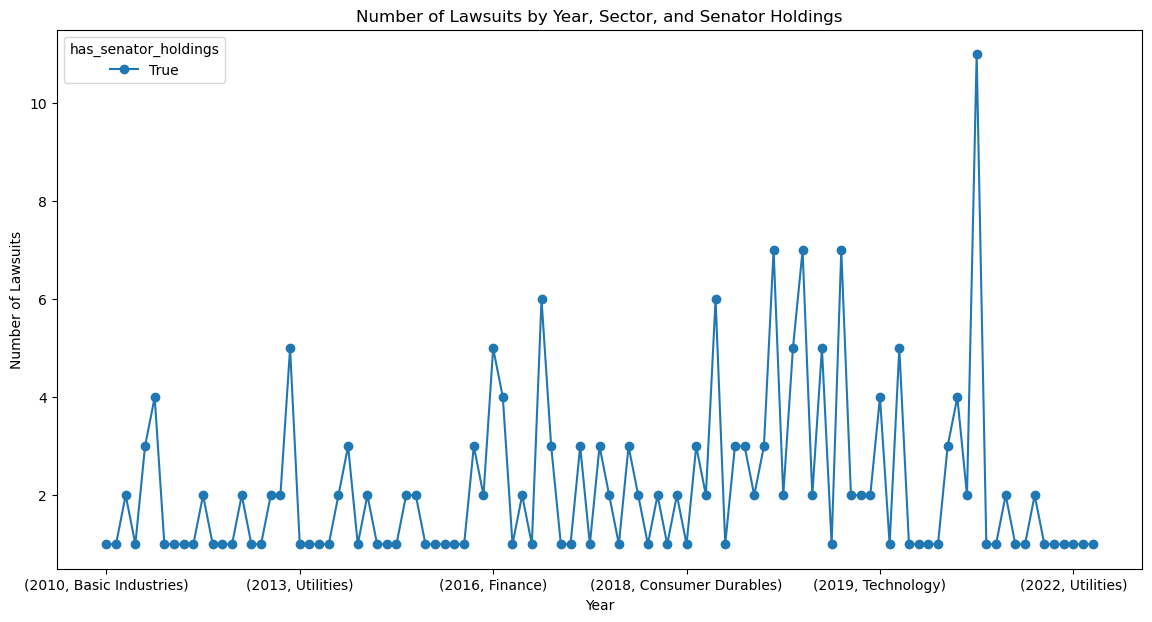

In [ ]:
settlement_dismissal_df['cld_fic_filing_dt'] = pd.to_datetime(settlement_dismissal_df['cld_fic_filing_dt'])

settlement_dismissal_df['year'] = settlement_dismissal_df['cld_fic_filing_dt'].dt.year

yearly_lawsuit_counts = settlement_dismissal_df.groupby(['year', 'Sector', 'has_senator_holdings']).size().unstack(fill_value=0)

yearly_lawsuit_counts.plot(kind='line', figsize=(14, 7), marker='o')
plt.title('Number of Lawsuits by Year, Sector, and Senator Holdings')
plt.xlabel('Year')
plt.ylabel('Number of Lawsuits')
plt.show()

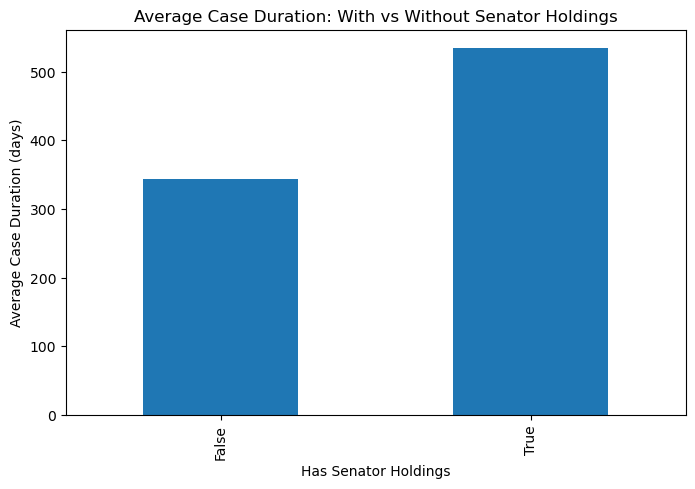

In [ ]:
# Duration of lawsuits
settlement_dismissal_df['case_duration'] = (pd.to_datetime(settlement_dismissal_df['cld_fic_class_end_dt']) - 
                                             pd.to_datetime(settlement_dismissal_df['cld_fic_class_start_dt'])).dt.days

avg_case_duration = settlement_dismissal_df.groupby('has_senator_holdings')['case_duration'].mean()

avg_case_duration.plot(kind='bar', figsize=(8, 5))
plt.title('Average Case Duration: With vs Without Senator Holdings')
plt.xlabel('Has Senator Holdings')
plt.ylabel('Average Case Duration (days)')
plt.show()

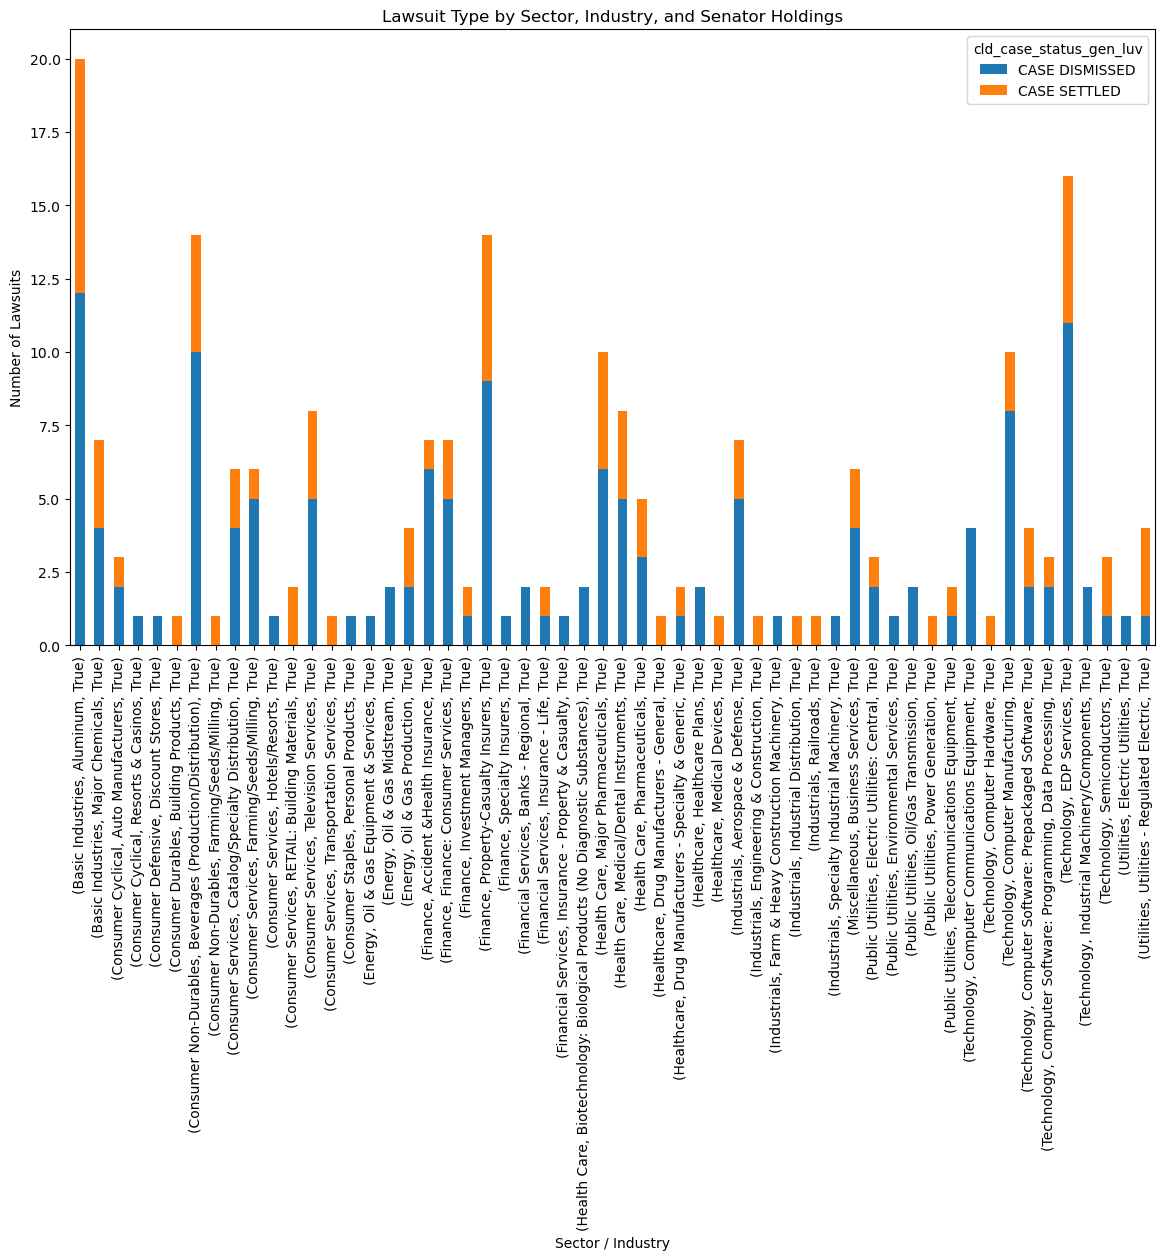

In [27]:
lawsuit_type_by_sector_industry = settlement_dismissal_df.groupby(['Sector', 'Industry', 'has_senator_holdings', 'cld_case_status_gen_luv']).size().unstack(fill_value=0)

lawsuit_type_by_sector_industry.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Lawsuit Type by Sector, Industry, and Senator Holdings')
plt.xlabel('Sector / Industry')
plt.ylabel('Number of Lawsuits')
plt.show()

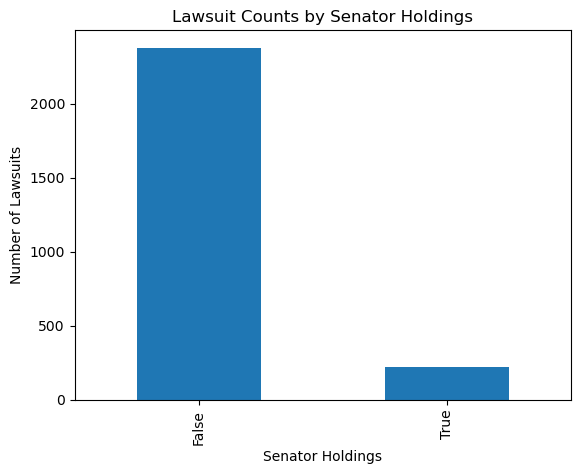

In [24]:
lawsuit_count_by_holdings = settlement_dismissal_df.groupby('has_senator_holdings')['composite_litigation_name'].count()

lawsuit_count_by_holdings.plot(kind='bar')
plt.title('Lawsuit Counts by Senator Holdings')
plt.xlabel('Senator Holdings')
plt.ylabel('Number of Lawsuits')
plt.show()